In [1]:
## Standard Libraries

In [2]:
%matplotlib inline

In [3]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import noise
import MotionClouds as mc

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [6]:
from LogGabor import LogGabor

## Noise stuff

In [7]:
def randomized_perlin_noise(shape=(128, 128), scale=10, octaves=6, persistence=0.5, lacunarity=2.0, base=0):
    noise_vector = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise_vector[i][j] = noise.pnoise2(i/scale,
                                               j/scale,
                                               octaves=int(
                                                   octaves * abs(np.random.randn()))+1,
                                               persistence=persistence *
                                               abs(np.random.randn()),
                                               lacunarity=lacunarity *
                                               abs(np.random.randn()),
                                               repeatx=shape[0],
                                               repeaty=shape[1],
                                               base=base)

    return noise_vector

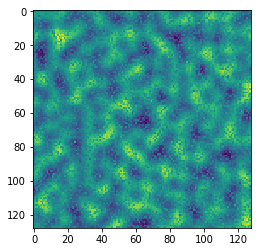

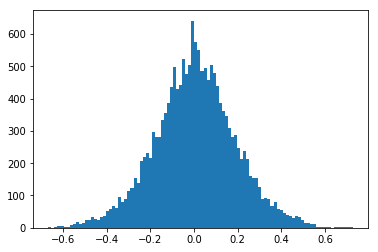

In [8]:
image = randomized_perlin_noise() 
plt.imshow(image)
plt.figure()
f = plt.hist(image.flatten(),100)

In [9]:
def MotionCloudNoise(sf_0=0.125, B_sf=3., alpha = .5):
    mc.N_X, mc.N_Y, mc.N_frame = 128, 128, 1
    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    name = 'static'
    env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=B_sf, B_theta=np.inf, V_X=0., V_Y=0., B_V=0, alpha= alpha)
    
    z = mc.rectif(mc.random_cloud(env))
    z = z.reshape((mc.N_X, mc.N_Y))
    return z, env


/usr/local/lib/python3.5/dist-packages/MotionClouds.py:94: RuntimeWarning: invalid value encountered in true_divide
  z = (.5* z/np.max(np.abs(z[:]))* contrast + .5)


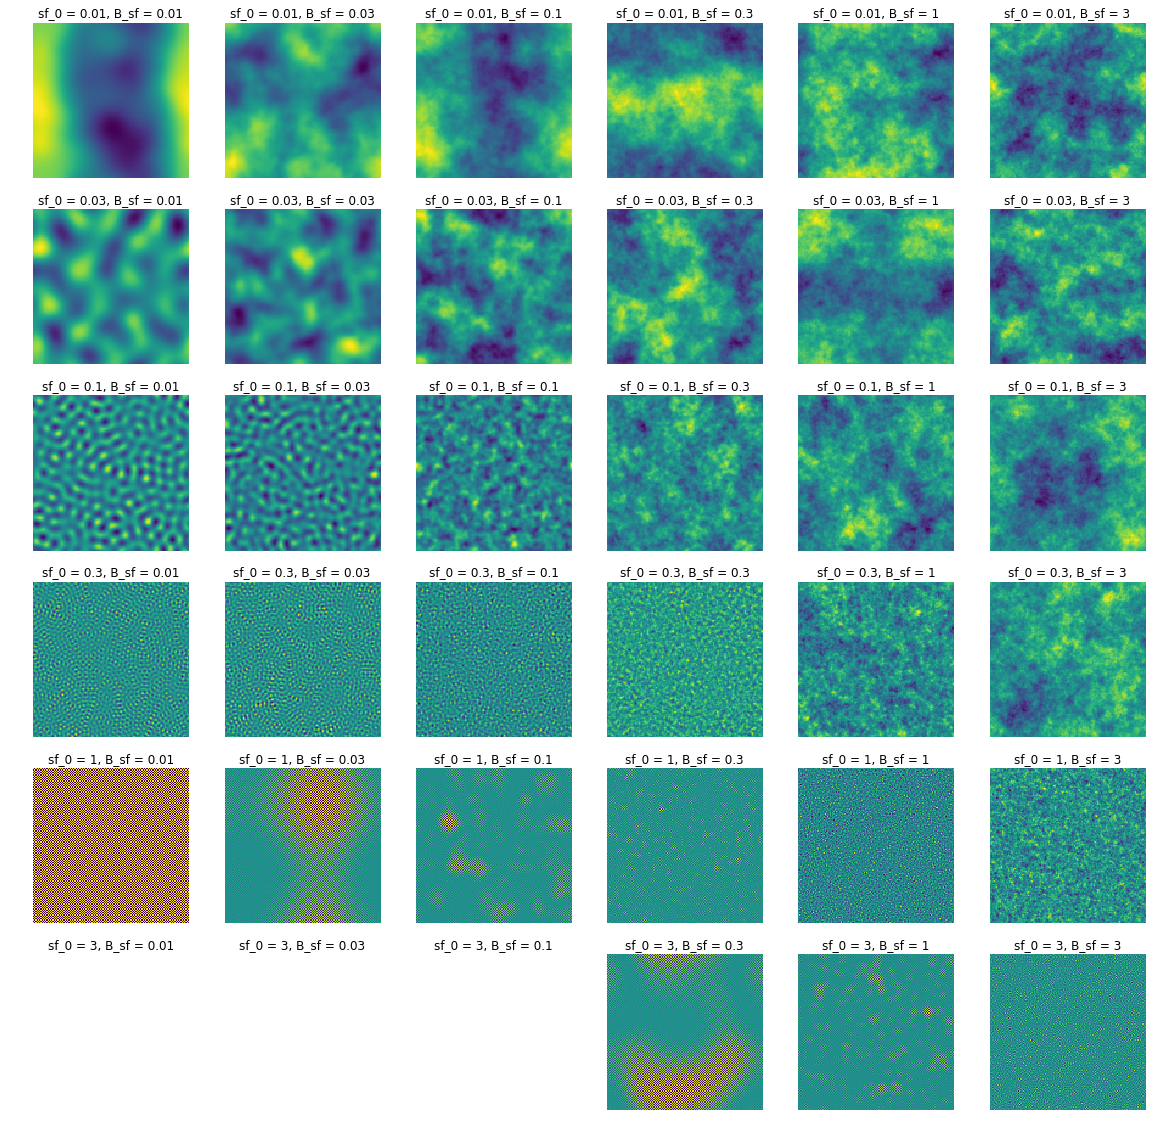

In [10]:
plt.figure(figsize = (20,20))
for i, sf_0 in enumerate([0.01, 0.03, 0.1, 0.3, 1, 3]):
    for j, B_sf in enumerate([0.01, 0.03, 0.1, 0.3, 1, 3]):
        image, env = MotionCloudNoise(sf_0 = sf_0, B_sf=B_sf)       
        plt.subplot(6,6,i * 6 + j + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("sf_0 = %.3g, B_sf = %.3g"%(sf_0, B_sf))

/usr/local/lib/python3.5/dist-packages/MotionClouds.py:94: RuntimeWarning: invalid value encountered in true_divide
  z = (.5* z/np.max(np.abs(z[:]))* contrast + .5)


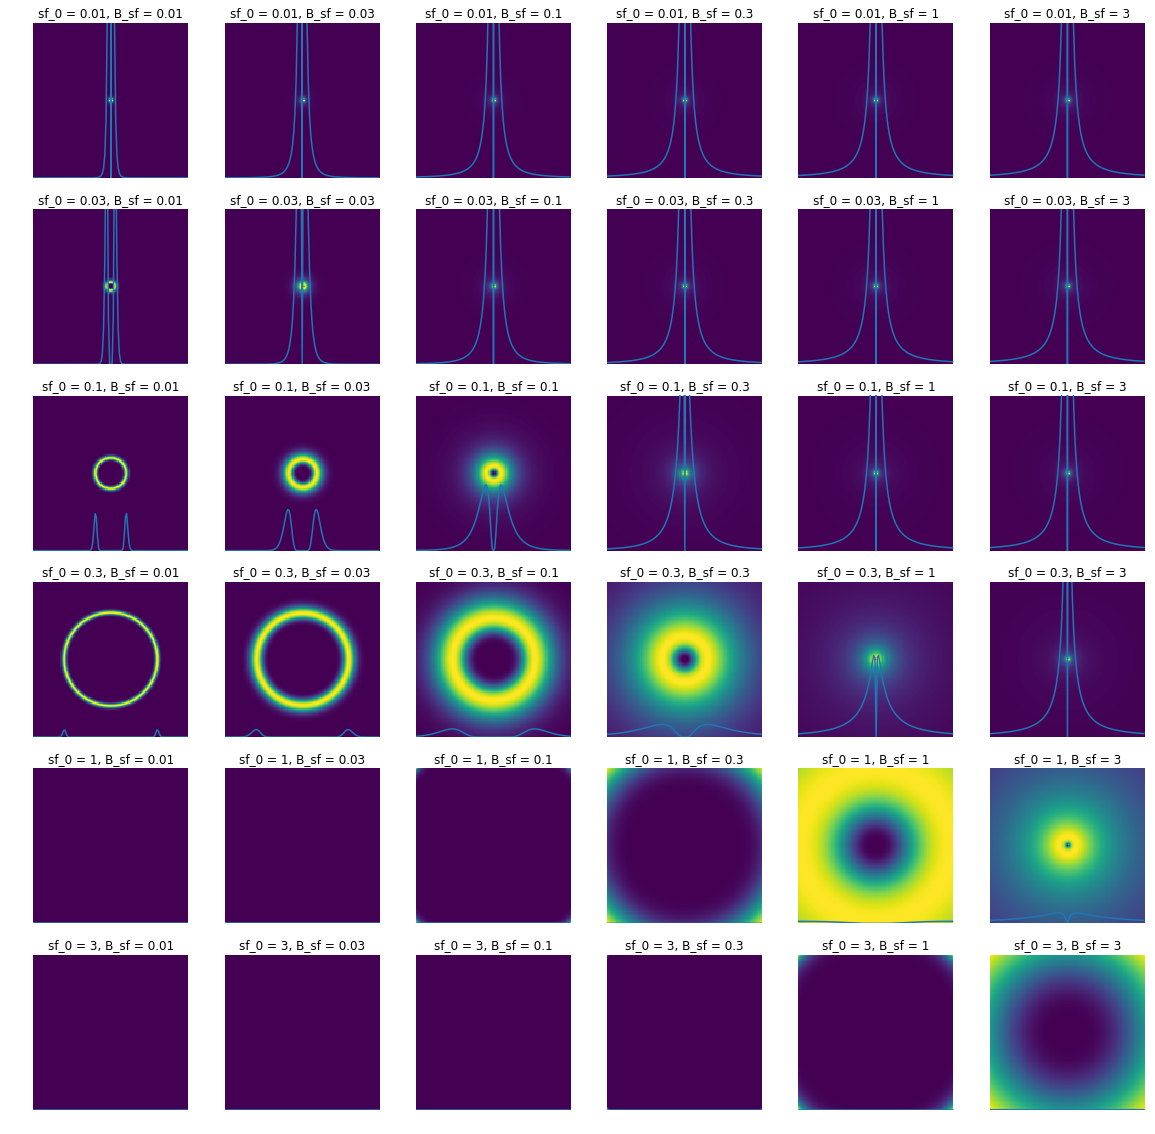

In [11]:
plt.figure(figsize = (20,20))
for i, sf_0 in enumerate([0.01, 0.03, 0.1, 0.3, 1, 3]):
    for j, B_sf in enumerate([0.01, 0.03, 0.1, 0.3, 1, 3]):
        image, env = MotionCloudNoise(sf_0 = sf_0, B_sf=B_sf)       
        plt.subplot(6,6,i * 6 + j + 1)
        plt.imshow(env.reshape((128,128)))
        plt.plot(env[64,:])
        plt.axis('off')
        plt.xlim([0, 128])
        plt.ylim([0, 128])
        plt.title("sf_0 = %.3g, B_sf = %.3g"%(sf_0, B_sf))

### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

In [12]:
# TODO: passer les arguments par la ligne de commande
N_theta = 6
N_azimuth = 12
N_eccentricity = 8
N_phase = 2
N_X = 128
N_Y = 128
rho = 1.41
verbose = 1
OFFSET_STD = 15
OFFSET_MAX = 30
NOISE = 1
CONTRAST = 0.3

#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [13]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=.8, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * \
                    np.cos((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                y = N_Y/2 + r * \
                    np.sin((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': i_theta*np.pi/N_theta, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()


    return retina


#### Full encoding

In [14]:
retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina.shape)

(6, 12, 8, 2, 16384)


In [15]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1152, 16384)


In [16]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1152)


#### Orientation invariant power encoding (colliculus??)

In [17]:
colliculus = (retina**2).sum(axis=(0, 3))
colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(12, 8, 16384)


In [18]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(96, 16384)


In [19]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 96)


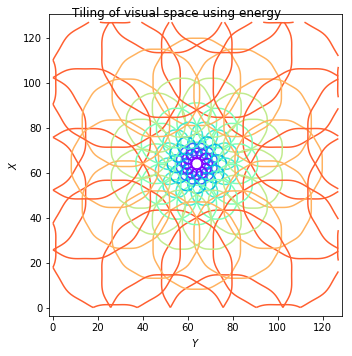

In [20]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

#### MNIST dataset read out

In [21]:
def get_data_loader(batch_size=100, train=True):
    data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/tmp/data',
                       train=train,     # def the dataset as training data
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0,), std=(1,))])),
                       batch_size=batch_size,
                       shuffle=True)
    return data_loader


In [22]:
loader = get_data_loader(batch_size=1, train = False)

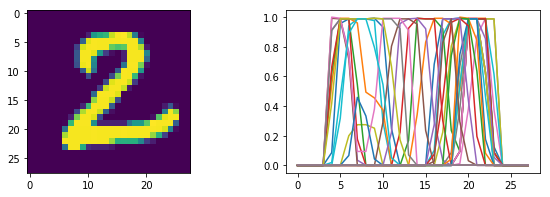

In [23]:
data, label = next(iter(loader))
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(data[0,0,:,:])
plt.subplot(122)
_ = plt.plot(data[0,0,:,:])

### From MNIST encoding

#### Input vectors encoding

In [24]:
def mnist_fullfield(data, i_offset, j_offset, N_pic=128, CONTRAST=1., NOISE = 1., sf_0 = 0.1, B_sf = 0.1):
    N_stim = data.shape[0]
    center = (N_pic-N_stim)//2

    data_fullfield = (data.min().numpy()) * np.ones((N_pic, N_pic))
    data_fullfield[int(center+i_offset):int(center+N_stim+i_offset), int(center+j_offset):int(center+N_stim+j_offset)] = data

    # data normalization
    # data_fullfield -= data_fullfield.mean()
    # data_fullfield /= data_fullfield.std()
    # data_fullfield *= std
    # data_fullfield += mean
    data_fullfield = (data_fullfield - data_fullfield.min())/(data_fullfield.max() - data_fullfield.min())
    data_fullfield *= CONTRAST

    if NOISE>0.:
        im_noise, _ = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf)
        im_noise = NOISE *  im_noise
        data_fullfield += im_noise #randomized_perlin_noise() #
        #indices_data = np.where(data_fullfield > data.mean())
        #im_noise[indices_data] = data_fullfield[indices_data]
        #data_fullfield = im_noise

    data_retina = retina_vector @ np.ravel(data_fullfield)

    return data_retina, data_fullfield

#### Output vectors (Accuracy/Saliency map) encoding

In [25]:
def accuracy_fullfield(accuracy, i_offset, j_offset, N_pic=128):
    N_stim = accuracy.shape[0]
    center = (N_pic-N_stim)//2

    accuracy_fullfield = 0.1 * np.ones((N_pic, N_pic))
    accuracy_fullfield[int(center+i_offset):int(center+N_stim+i_offset),
                 int(center+j_offset):int(center+N_stim+j_offset)] = accuracy

    accuracy_colliculus = colliculus_vector @ np.ravel(accuracy_fullfield)

    return accuracy_colliculus, accuracy_fullfield

(128, 128, 1)


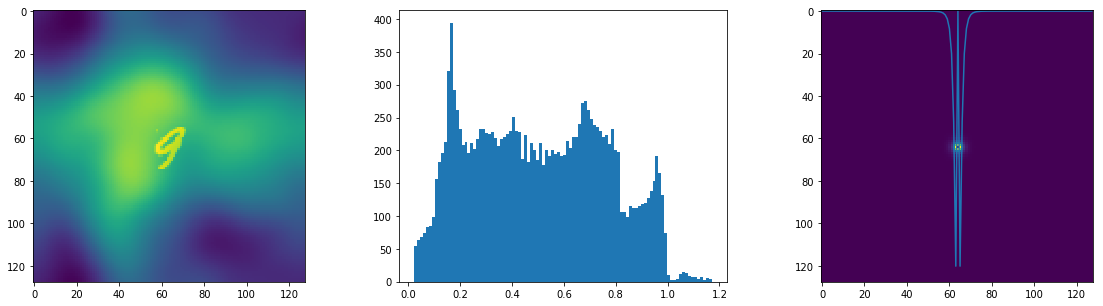

In [26]:
sf_0 = 0.01
B_sf = 0.01
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf, alpha = 0) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])

(128, 128, 1)


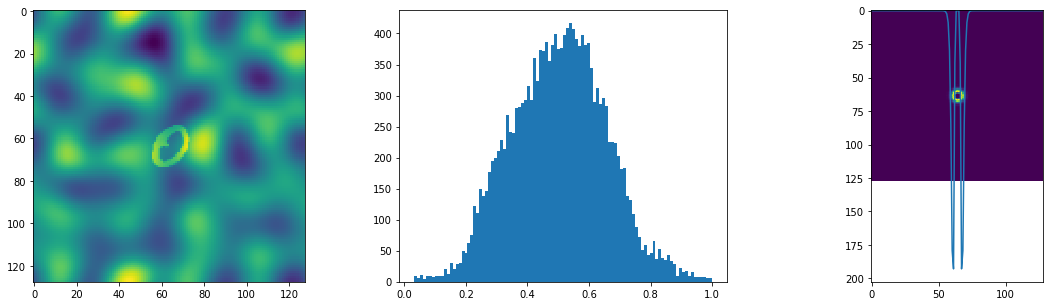

In [27]:
sf_0 = 0.03
B_sf = 0.01
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])

(128, 128, 1)


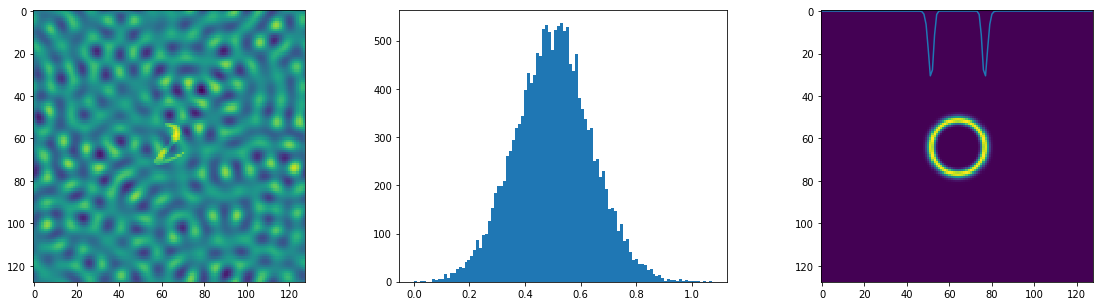

In [28]:
sf_0 = 0.1
B_sf = 0.01
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])

(128, 128, 1)


(0, 128)

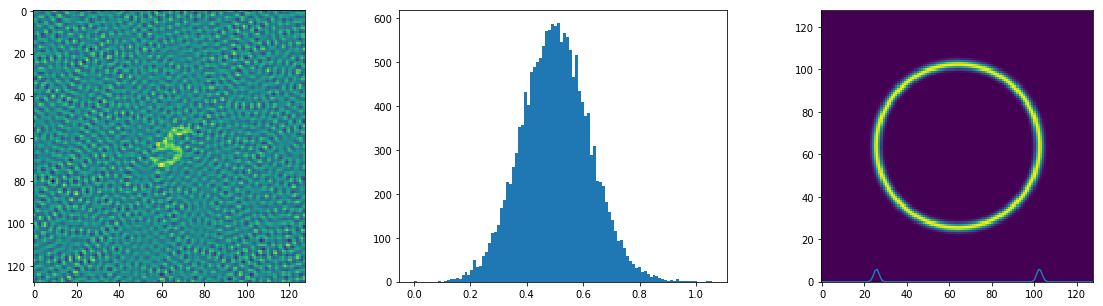

In [29]:
sf_0 = 0.3
B_sf = 0.01
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])
plt.ylim([0, 128])

(128, 128, 1)


(0, 128)

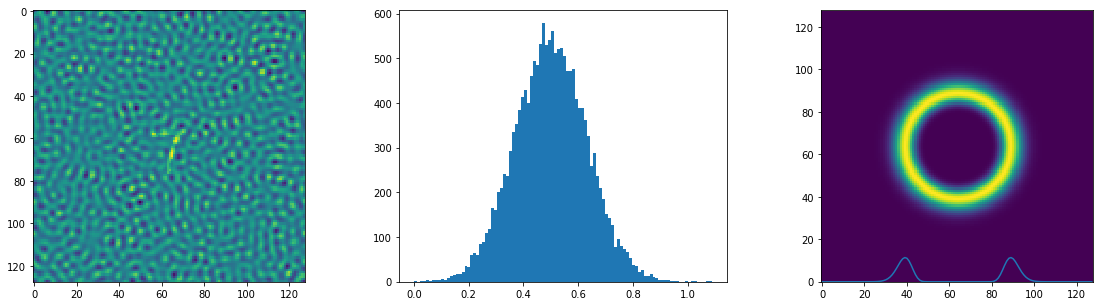

In [30]:
sf_0 = 0.2
B_sf = 0.03
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])
plt.ylim([0, 128])

(128, 128, 1)


(0, 128)

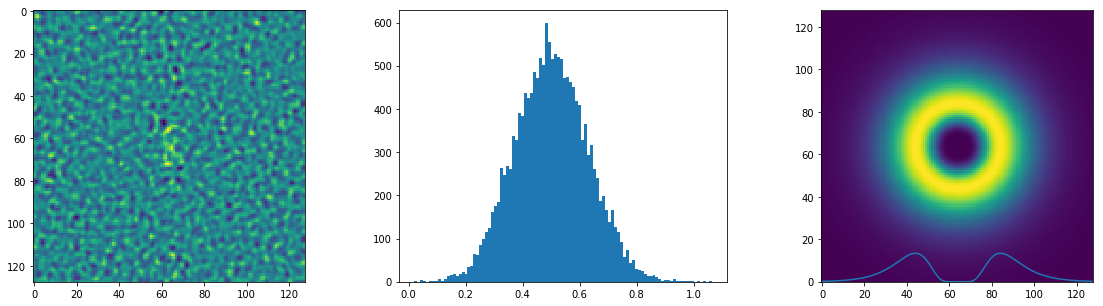

In [31]:
sf_0 = 0.2
B_sf = 0.1
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])
plt.ylim([0, 128])

(128, 128, 1)


(0, 128)

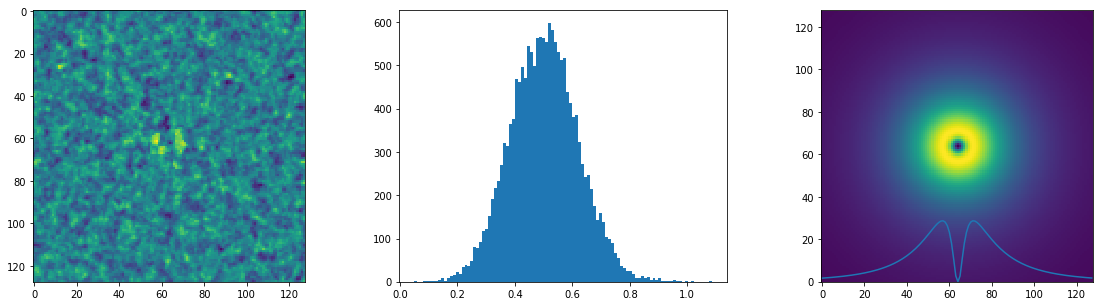

In [32]:
sf_0 = 0.2
B_sf = 0.3
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])
plt.ylim([0, 128])

(128, 128, 1)


(0, 128)

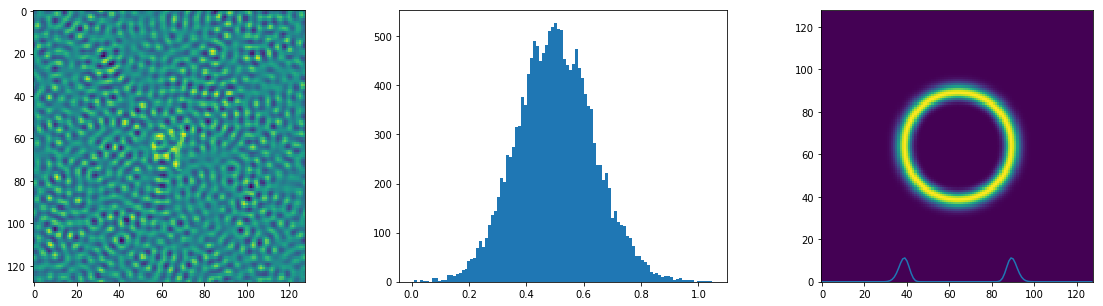

In [33]:
sf_0 = 0.2
B_sf = 0.02
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])
plt.ylim([0, 128])

(128, 128, 1)


(0, 128)

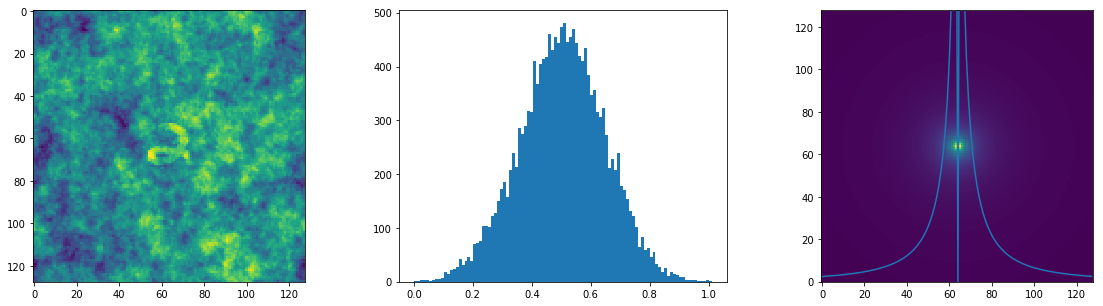

In [34]:
sf_0 = 0.2
B_sf = 1
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])
plt.ylim([0, 128])

(128, 128, 1)


(0, 128)

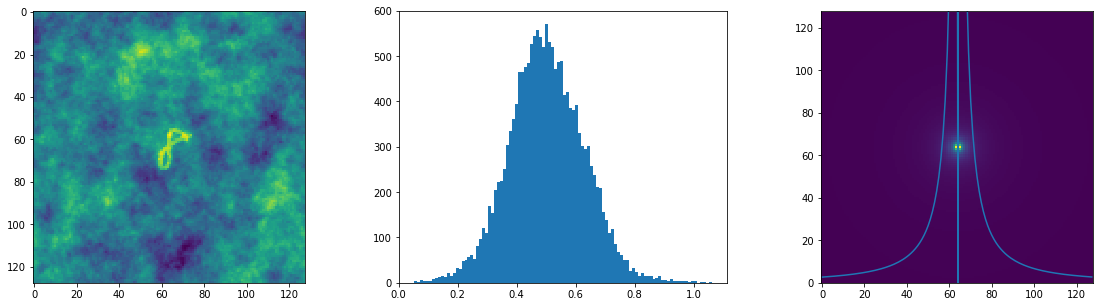

In [35]:
sf_0 = 0.2
B_sf = 3
NOISE = 1
CONTRAST = .3

_, env = MotionCloudNoise(sf_0 = sf_0, B_sf = B_sf) 
mnist_image, _ = next(iter(loader))
_, image = mnist_fullfield(mnist_image[0,0,:,:], 0, 0, N_pic=128, NOISE=NOISE,  CONTRAST=CONTRAST, sf_0 = sf_0, B_sf = B_sf)
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
f = plt.hist(image.flatten(),100)
plt.subplot(1,3,3)
plt.imshow(env.reshape((128,128)))
print(env.shape)
plt.plot(env[64,:])
plt.ylim([0, 128])

## Accuracy Map

#### Charger la matrice de certitude

In [36]:
path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy =  np.load(path)
    if verbose:
        print('Loading accuracy... min, max=', accuracy.min(), accuracy.max())
else:
    print('No accuracy data found.')


Loading accuracy... min, max= 0.0145 0.9852


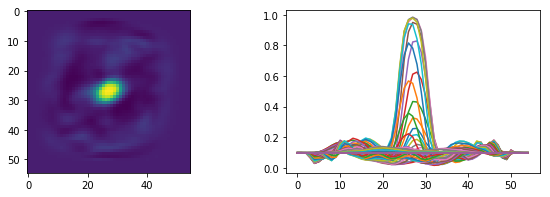

In [37]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(accuracy)
plt.subplot(122)
_ = plt.plot(accuracy)

#### Utilitaires

In [38]:
def couples(data, i_offset, j_offset, CONTRAST=1., NOISE = 1.,
            sf_0 = sf_0, B_sf = B_sf): #, device):
    #data = data.to(device)
    v, _ = mnist_fullfield(data, i_offset, j_offset, 
                           CONTRAST = CONTRAST, NOISE = NOISE,
                           sf_0 = sf_0, B_sf = B_sf)
    a, _ = accuracy_fullfield(accuracy, i_offset, j_offset)
    return (v, a)

In [39]:
def full_couples(data, i_offset, j_offset, CONTRAST=1., NOISE = 1.,
                 sf_0 = sf_0, B_sf = B_sf): #, device):
    #data = data.to(device)
    _, v = mnist_fullfield(data, i_offset, j_offset, 
                           CONTRAST = CONTRAST, NOISE = NOISE,
                           sf_0 = sf_0, B_sf = B_sf)
    _, a = accuracy_fullfield(accuracy, i_offset, j_offset)
    return (v, a)

In [40]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

### Test

In [41]:
if False:
    i = 0
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_test, a_data_test = full_couples(data[i, 0, :, :], i_offset, j_offset, CONTRAST = CONTRAST, NOISE = NOISE)
    plt.imshow(input_test)
    plt.figure()
    plt.imshow(a_data_test)
    plt.figure()
    f = plt.plot(input_test)

# Hyperparameters

In [42]:
minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-3 #0.05
#n_hidden1 = int(((N_theta*N_azimuth*N_eccentricity*N_phase)/4)*3)
#n_hidden2 = int(((N_theta*N_azimuth*N_eccentricity*N_phase)/4))

n_hidden1 = 200 #80
n_hidden2 = 80 #200

print('n_hidden1', n_hidden1, ' / n_hidden2', n_hidden2)
verbose = 1
#mean, std = 0.13,  .3
mean, CONTRAST = 0.,  .3
NOISE = 1.
sf_0 = 0.2
B_sf = 0.1

n_hidden1 200  / n_hidden2 80


#### Torch stuff

In [43]:
do_cuda = False # torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [44]:
train_loader = get_data_loader(batch_size=minibatch_size, train = True)
test_loader = get_data_loader(batch_size=1000, train = False)

# Network

In [45]:
class Net(torch.nn.Module):
    
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.predict = torch.nn.Linear(n_hidden2, n_output)
        #self.dropout = nn.Dropout(p = 0.5) 
        
    def forward(self, data, do_leaky_relu=True):
        data = F.relu(self.hidden1(data))
        data = F.relu(self.hidden2(data))
        data = F.dropout(data, p = .5) #self.dropout)
        data =  self.predict(data)
        return data


In [46]:
net = Net(n_feature=N_theta*N_azimuth*N_eccentricity*N_phase,\
          n_hidden1=n_hidden1,\
          n_hidden2=n_hidden2,\
          n_output=N_azimuth*N_eccentricity)

In [47]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [48]:
loss_func = torch.nn.BCEWithLogitsLoss()

In [49]:
#### Training

In [53]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = N_azimuth * N_eccentricity, \
          offset_std=OFFSET_STD, \
          offset_max=OFFSET_MAX, \
          verbose=1, \
          CONTRAST=CONTRAST,
          NOISE = NOISE,
          sf_0 = sf_0, 
          B_sf = B_sf):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        input_ = np.zeros((minibatch_size, 1, vsize))
        a_data = np.zeros((minibatch_size, 1, asize))
        # target = np.zeros((minibatch_size, asize))

        for idx in range(minibatch_size):
            i_offset = minmax(np.random.randn() * offset_std, offset_max)
            j_offset = minmax(np.random.randn() * offset_std, offset_max)
            input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :, :], i_offset, j_offset, 
                                                           CONTRAST=CONTRAST, NOISE = NOISE,
                                                           sf_0 = sf_0, B_sf = B_sf)

        #input_, target = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(a_data))
        input_, a_data = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(a_data))
        #input_, a_data = input_.to(device), a_data.to(device)
        #print('a_data.numpy()', a_data.numpy().shape)
        #print('... min, max=', a_data.numpy().min(), a_data.numpy().max())
        prediction = net(input_)
        #loss = loss_func(prediction, target)
        loss = loss_func(prediction, a_data)


        #input_, target = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(a_data))
        # input_, target = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(target))
        # data, target = data.to(self.device), target.to(self.device)

        # prediction = net(input_)
        # loss = loss_func(prediction, target)

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            print('[{}/{}] Loss: {} Time: {:.2f} mn'.format(
                batch_idx*minibatch_size, len(train_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))
    return net


In [54]:
def test(net, minibatch_size, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity, offset_std=OFFSET_STD, offset_max=OFFSET_MAX, 
         CONTRAST=CONTRAST, NOISE = NOISE,
         sf_0 = sf_0, 
         B_sf = B_sf):
    #for batch_idx, (data, label) in enumerate(test_loader):
    data, label = next(iter(test_loader))
    
    input_, a_data = np.zeros((minibatch_size, 1, vsize)), np.zeros(
        (minibatch_size, 1, asize))
    target = np.zeros((minibatch_size, asize))
    for idx in range(minibatch_size):
        i_offset, j_offset = minmax(np.random.randn()*offset_std, offset_max), minmax(np.random.randn()*offset_std, offset_max)
        input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :], i_offset, j_offset, 
                                                       CONTRAST=CONTRAST, NOISE = NOISE,
                                                       sf_0 = sf_0, B_sf = B_sf)
        target[idx, :] = a_data[idx, 0, :]

    input_ = Variable(torch.FloatTensor(input_))
    target = Variable(torch.FloatTensor(a_data))

    prediction = net(input_)
    loss = loss_func(prediction, target)

    return loss.data.numpy()


In [60]:
for epoch in range(1):
    train(net, minibatch_size)
    Accuracy = test(net, minibatch_size)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 0.36386188864707947 Time: 0.04 mn
[1000/60000] Loss: 0.3599739670753479 Time: 0.46 mn
[2000/60000] Loss: 0.35734841227531433 Time: 0.91 mn
[3000/60000] Loss: 0.35560086369514465 Time: 1.41 mn
[4000/60000] Loss: 0.35828953981399536 Time: 1.90 mn
[5000/60000] Loss: 0.3550693094730377 Time: 2.37 mn
[6000/60000] Loss: 0.35619163513183594 Time: 2.89 mn
[7000/60000] Loss: 0.3533613383769989 Time: 3.42 mn
[8000/60000] Loss: 0.3526526391506195 Time: 3.96 mn
[9000/60000] Loss: 0.3530760407447815 Time: 4.38 mn
[10000/60000] Loss: 0.35180673003196716 Time: 4.79 mn
[11000/60000] Loss: 0.3557564914226532 Time: 5.22 mn
[12000/60000] Loss: 0.35458216071128845 Time: 5.65 mn
[13000/60000] Loss: 0.35539308190345764 Time: 6.13 mn
[14000/60000] Loss: 0.352340966463089 Time: 6.67 mn
[15000/60000] Loss: 0.35549086332321167 Time: 7.25 mn
[16000/60000] Loss: 0.35765302181243896 Time: 7.79 mn
[17000/60000] Loss: 0.3534591794013977 Time: 8.30 mn
[18000/60000] Loss: 0.3528465

KeyboardInterrupt: 

In [379]:
for epoch in range(1):
    train(net, minibatch_size)
    Accuracy = test(net, minibatch_size)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 0.8438740372657776 Time: 0.04 mn
[1000/60000] Loss: 0.43461495637893677 Time: 0.46 mn
[2000/60000] Loss: 0.38012373447418213 Time: 0.89 mn
[3000/60000] Loss: 0.3721243739128113 Time: 1.32 mn
[4000/60000] Loss: 0.36370354890823364 Time: 1.75 mn
[5000/60000] Loss: 0.36942991614341736 Time: 2.20 mn
[6000/60000] Loss: 0.36292675137519836 Time: 2.67 mn
[7000/60000] Loss: 0.3655562102794647 Time: 3.11 mn
[8000/60000] Loss: 0.3656441271305084 Time: 3.55 mn
[9000/60000] Loss: 0.3622300624847412 Time: 4.02 mn
[10000/60000] Loss: 0.3591260612010956 Time: 4.45 mn
[11000/60000] Loss: 0.36152708530426025 Time: 4.91 mn
[12000/60000] Loss: 0.36249464750289917 Time: 5.35 mn
[13000/60000] Loss: 0.3590739071369171 Time: 5.79 mn
[14000/60000] Loss: 0.36583787202835083 Time: 6.22 mn
[15000/60000] Loss: 0.36508288979530334 Time: 6.67 mn
[16000/60000] Loss: 0.3611541986465454 Time: 7.15 mn
[17000/60000] Loss: 0.3604412376880646 Time: 7.59 mn
[18000/60000] Loss: 0.3697756

In [61]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=OFFSET_STD
offset_max=OFFSET_MAX

data, label = next(iter(test_loader))
input_ = np.zeros((minibatch_size, 1, vsize))
a_data = np.zeros((minibatch_size, 1, asize))
        # target = np.zeros((minibatch_size, asize))

for idx in range(minibatch_size):
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :, :], i_offset, j_offset, CONTRAST=CONTRAST)

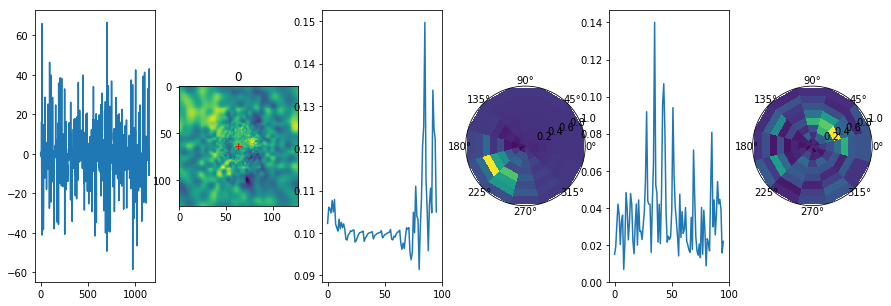

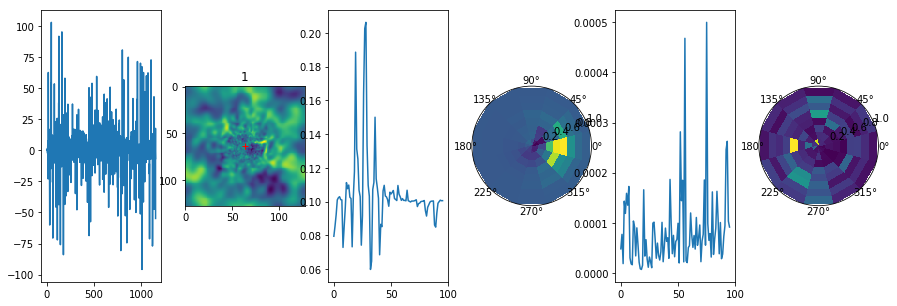

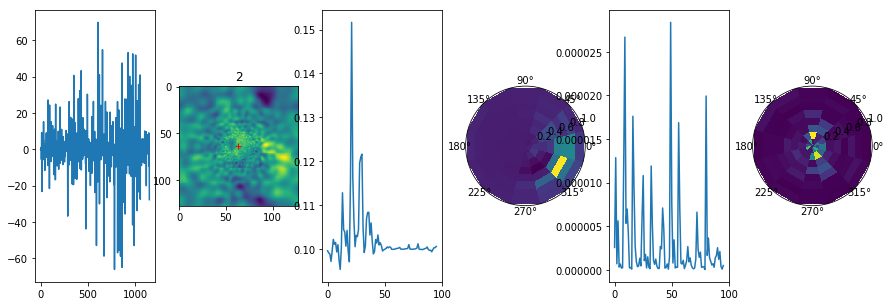

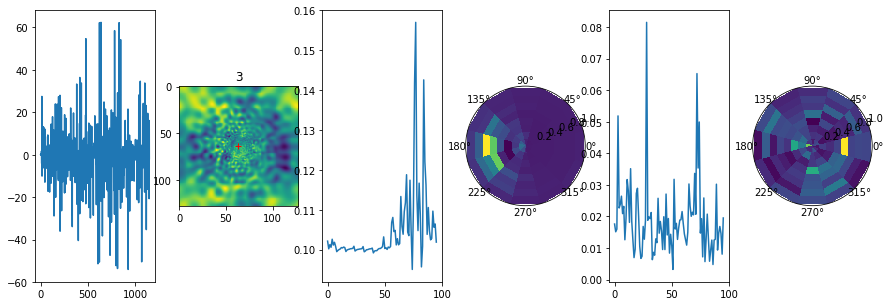

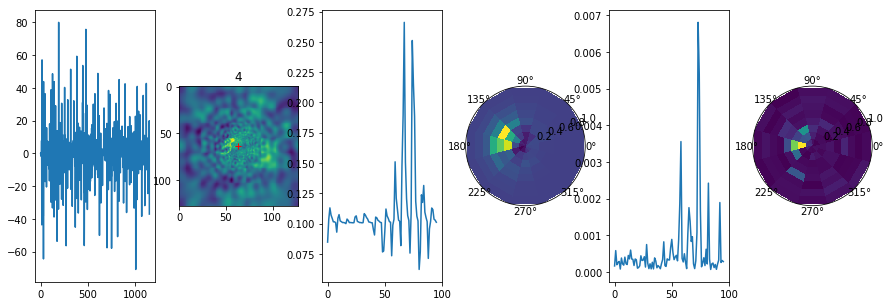

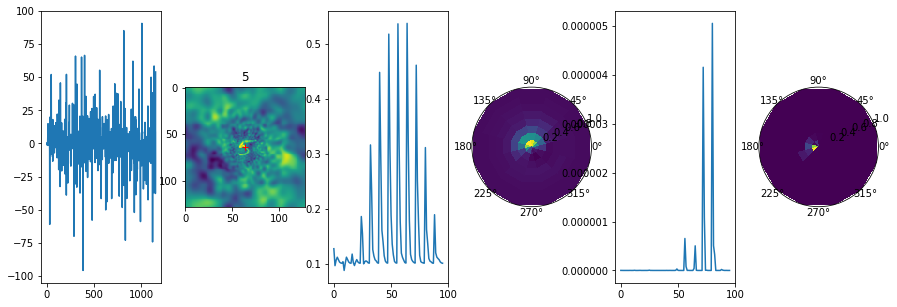

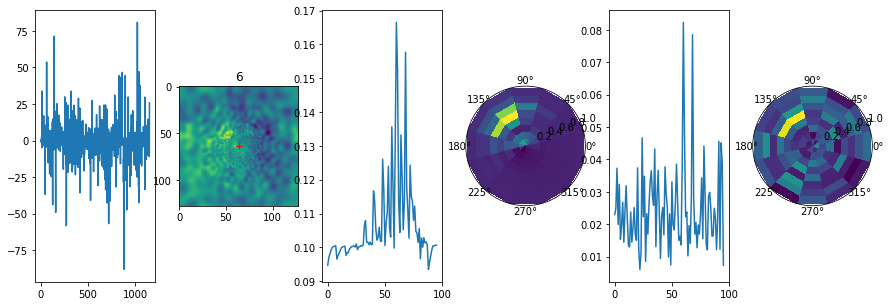

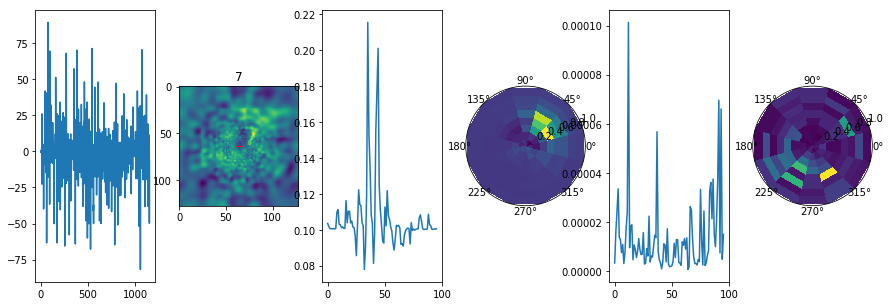

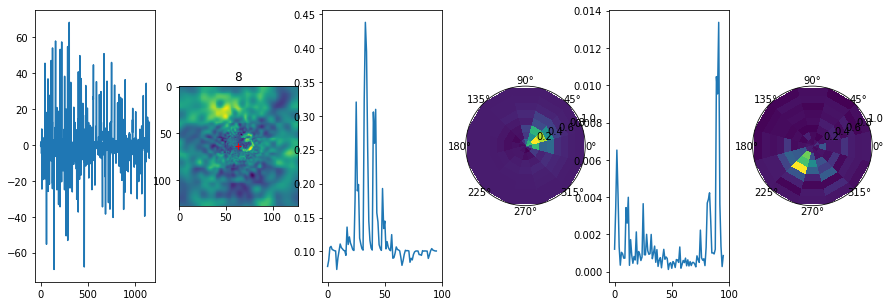

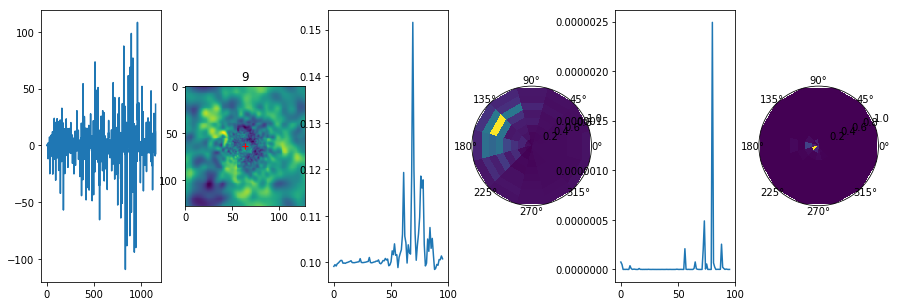

In [62]:
delta = 1/N_azimuth
log_r, theta = np.meshgrid(np.linspace(0, 1, N_eccentricity + 1), np.linspace(-np.pi*(.5 + delta), np.pi*(1.5 - delta), N_azimuth + 1))
for _ in range(10):
    im = retina_inverse @ input_[_,0,:]
    plt.figure(figsize = (15, 5))
    plt.subplot(161)
    plt.plot(input_[_,0,:])
    plt.subplot(162)
    plt.imshow(im.reshape(128, 128))
    plt.plot(63.5, 63.5, 'r+')
    plt.title(_)
    plt.subplot(163)
    plt.plot(a_data[_,0,:])    
    col = colliculus_inverse @ a_data[_,0,:]
    ax = plt.subplot(164, projection='polar')
    vec = a_data[_,0,:]
    ax.pcolor(theta, log_r, vec.reshape((12, 8)))
    #plt.imshow(col.reshape(128, 128))
    in_ = Variable(torch.FloatTensor(input_[_,0,:]))
    out = net(in_)
    plt.subplot(165)
    out_sig = F.sigmoid(out).detach().numpy()
    plt.plot(out_sig)    
    view = colliculus_inverse @ out_sig
    ax = plt.subplot(166, projection='polar')
    ax.pcolor(theta, log_r, out_sig.reshape((12, 8)))
    #plt.imshow(view.reshape(128, 128))
                                 

In [ ]:
N_eccentricity